In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from train import *


def restore(
    tpu_id='t8d',
    seed=42,
    path = 'jigsaw/r000//20200425_010629_t8d',
    gcs='hm-eu-w4',
    dataset='../input/jigsaw-mltc-ds/jigsaw_mltc_ds436001s.npz',
    model_id='jplu/tf-xlm-roberta-large',
    stages=10,
    dropout=                                                          0,
    weight_decay  =                                         1.48392e-06,
    warm_up     =                                               2.31104,
    pos_weight   =                                              1.19586,
    optimizer  =                                                    'LAMB',
    one_cycle   =                                                  True,
    lr          =                                           8.54311e-05,
    loss_fn     =                                                 'focal',
    label_smoothing =                                          0.003802,
    gamma          =                                            1.19951,
    epochs         =                                                 30,
    callback       =                                               None,
    batch_size      =                                                28):
    
    params = pd.DataFrame(dict(locals()), index=[0])
    print(params.T)
    gc.collect()

    if tpu_id is None:
        with open('tpu', 'r') as content_file:
            tpu_id = content_file.read()
            print(dict(tpu_id=tpu_id))

    ## Detect hardware, return appropriate distribution strategy
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=tpu_id)
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()
    print("REPLICAS: ", strategy.num_replicas_in_sync)

    ## Configuration
    batch_size = batch_size * strategy.num_replicas_in_sync if tpu else 1
    max_len=192

    gcs_path = f'gs://{gcs}/{path}'
    print('gcs_path:', gcs_path)
    print('batch_size:', batch_size)

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

    array = np.load(dataset)
    x_train, x_valid, x_test, y_train, y_valid = [array[k] for k in list(array)]
    assert x_train.dtype is np.dtype('int32')
    print(x_train.shape, x_valid.shape, x_test.shape, y_train.shape, y_valid.shape)

    # epoch duration
    steps_per_epoch = (x_train.shape[0] // batch_size) // stages

    def build_model(transformer, max_len=512, dropout=dropout):
        """ https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras """
        input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
        sequence_output = transformer(input_word_ids)[0]
        cls_token = sequence_output[:, 0, :]
        if dropout > 0:
            cls_token = Dropout(dropout)(cls_token)
        out = Dense(1, activation='sigmoid')(cls_token)
        model = Model(inputs=input_word_ids, outputs=out)

        if loss_fn == 'focal':
            loss = focal_loss(pos_weight=pos_weight, gamma=gamma, label_smoothing=label_smoothing)
        elif loss_fn == 'bce':
            loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=label_smoothing)

        if optimizer == 'LAMB':
            opt = tfa.optimizers.LAMB(lr=lr, weight_decay_rate=weight_decay)
        elif optimizer == 'AdamW':
            opt = tfa.optimizers.AdamW(lr=lr, weight_decay=weight_decay)

    #         if moving_average is not None and moving_average > 0:
    #             opt = tfa.optimizers.MovingAverage(opt, average_decay=moving_average)

        model.compile(
                optimizer=opt,
                loss=loss,
                metrics=['accuracy',
                         tf.keras.metrics.AUC(name='auc'),
                        ]
            )

        return model


    def save_fig(filename, path=path, bucket=gcs):
        plt.gcf().savefig(filename)
        plt.close()
        # init GCS client and upload file
        client = storage.Client()
        bucket = client.get_bucket('hm-eu-w4')
        blob = bucket.blob(f'{path}/' + filename)
        content = blob.upload_from_filename(filename=filename)


    ## Load
    with strategy.scope():
        transformer_layer = TFAutoModel.from_pretrained(model_id)
        model = build_model(transformer_layer, max_len=max_len)

    # load best
    # latest = tf.train.latest_checkpoint(checkpoint_dir)
    checkpoint_path = f'{gcs_path}/best_model.tf'
    with strategy.scope():
        model.load_weights(checkpoint_path)

    valid_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid)).batch(batch_size)
    preds = model.predict(valid_dataset, verbose=1)

    ## Load Dataset
    valid = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
    #     test = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/test.csv')
    sub = pd.read_csv('../input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

    valid['pred'] = preds
    valid.to_csv(f'{gcs_path}/valid_oof.csv', index=False)

    ax = valid.groupby('toxic').pred.hist(bins=100, log=True, alpha=0.5)
    plt.legend([0, 1])
    save_fig('valid_hist.png')

    ax = valid[valid.toxic == 1].groupby('lang').pred.hist(bins=50, log=True, alpha=0.34)
    plt.legend(valid.lang.unique())
    save_fig('valid_toxic_hist.png')

    valid_auc = roc_auc_score(valid.toxic, valid.pred)
    print('AUC:', valid_auc,
          'toxic:', valid.toxic.mean(),
          'pred:', valid.pred.mean(),
          'ratio:', (valid.pred > 0.5).mean())

    # over sample toxic
    bal_valid = valid.append(valid[valid.toxic == 1], ignore_index=True)
    print('AUC_bal:', roc_auc_score(bal_valid.toxic, bal_valid.pred),
          'toxic:', bal_valid.toxic.mean(),
          'pred:', bal_valid.pred.mean(),
          'ratio:', (bal_valid.pred > 0.5).mean())

    ## Submission
    test_dataset = tf.data.Dataset.from_tensor_slices(x_test).batch(batch_size)
    sub['toxic'] = model.predict(test_dataset, verbose=1)
    sub.to_csv(f'{gcs_path}/submission.csv', index=False)

    ax = sub.toxic.hist(bins=100, log=True)
    save_fig('sub_hist.png')
    print('mean:', sub.toxic.mean(), 'ratio:', (sub.toxic > 0.5).mean())

    ## Save params
    params['auc'] = valid_auc
    params.to_csv(f'{gcs_path}/params{valid_auc:04f}.csv', index=False)
    print(params.T)
    
    return params

restore()

                                                                 0
batch_size                                                      28
callback                                                      None
epochs                                                          30
one_cycle                                                     True
warm_up                                                    2.31104
dropout                                                          0
stages                                                          10
model_id                                 jplu/tf-xlm-roberta-large
dataset          ../input/jigsaw-mltc-ds/jigsaw_mltc_ds436001s.npz
gcs                                                       hm-eu-w4
path                              jigsaw/r000//20200425_010629_t8d
seed                                                            42
tpu_id                                                         t8d
weight_decay                                           1.48392

INFO:absl:Entering into master device scope: /job:worker/replica:0/task:0/device:CPU:0


REPLICAS:  8
gcs_path: gs://hm-eu-w4/jigsaw/r000//20200425_010629_t8d
batch_size: 224
(436001, 192) (8000, 192) (63812, 192) (436001,) (8000,)
36/36 [==============================] - 38s 1s/step
AUC: 0.9641984604484154 toxic: 0.15375 pred: 0.19126524 ratio: 0.137125
AUC_bal: 0.9641984604484154 toxic: 0.26652221018418204 pred: 0.25029644 ratio: 0.2134344528710726
285/285 [==============================] - 77s 271ms/step
mean: 0.23730642 ratio: 0.1857957750893249
                                                                 0
batch_size                                                      28
callback                                                      None
epochs                                                          30
one_cycle                                                     True
warm_up                                                    2.31104
dropout                                                          0
stages                                                          

,batch_size,callback,epochs,one_cycle,warm_up,dropout,stages,model_id,dataset,gcs,...,seed,tpu_id,weight_decay,pos_weight,optimizer,lr,loss_fn,label_smoothing,gamma,auc
0,28,None,30,True,2.31104,0,10,jplu/tf-xlm-roberta-large,../input/jigsaw-mltc-ds/jigsaw_mltc_ds436001s.npz,hm-eu-w4,...,42,t8d,0.000001,1.19586,LAMB,0.000085,focal,0.003802,1.19951,0.964198


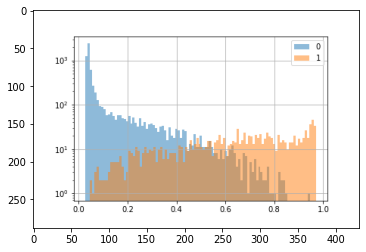

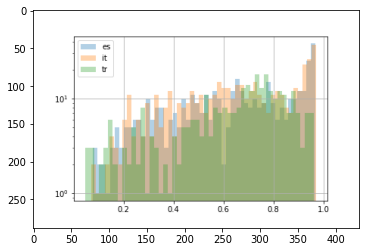

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('valid_hist.png')
_ = plt.imshow(img)
plt.show()
img = mpimg.imread('valid_toxic_hist.png')
_ = plt.imshow(img)

In [4]:
# import pdb; pdb.pm()

In [1]:
from train import *

